# Network Intrusion Detection Mini Project
## By: Yashver , Josiah & Anish

### Preliminary Code:

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, classification_report
from plotly.subplots import make_subplots
import plotly.express as px 
import plotly.graph_objects as go
from pandas.api.types import is_numeric_dtype
import seaborn as sb
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time


*Our dataset has 2 files provided already for Train and Test but we chose to use the Train Set only which we will split later on  to make sure the split is truly random*

In [2]:
intrusion = pd.read_csv("network.csv")

In [3]:
intrusionog=intrusion.copy()

## Data Cleaning and Preparation:

**Preliminary Exploration**

*Description of the Numerical Features*

In [4]:
intrusion.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*Description of the Categorical Features*

In [5]:
intrusion.describe(include = 'object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


*individually storing class to use later*

In [6]:
clss = pd.DataFrame(intrusion['class'])

*A look at the object types of each variable*

In [7]:
intrusion.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

**We check for missing values to ensure that the dataset is complete and accurate as it may lead to biased or inaccurate results and errors**

In [8]:
intrusion.isnull().values.any()

False

no NAN values in dataset

**Next, we check for duplicate rows as it may also create bias**

In [9]:
print(f"Number of duplicate rows: {intrusion.duplicated().sum()}")


Number of duplicate rows: 0


## Exploratory Data Analysis:

Our dataset consists of 41 features (independent var) and a class label (dependant var). The 41 features can be grouped into:

-Basic(9): Derived from header information of network packets. Eg: duration, protocol_type, service, etc.

-Content(13): Derived from packet payload. Eg: hot, num_failed_logins, logged_in, etc

-Traffic(9): Capture the behaviour of connecttions between same source and destination hosts. Eg: count, serror_rate, rerro_rate, etc.

-Traffic between different hosts(10): capture the behavior of connections between different source and destination hosts. Eg: dst_host_count, dst_host_srv_count, etc.

#### For our EDA, we first stared with Univariate analysis of our categorical and Numerical Features before moving on to bivariate analysis to gain a comprehensive understanding of the dataset.


**1. Exploring the Categorical Features**

=> To analyse the distribution of values within each feature and observe any patterns

In [10]:
categorical_features = ['protocol_type' , 'service', 'flag']
categorical_featureswclass = ['protocol_type' , 'service', 'flag','class']


for v in categorical_features:
    print(f"=====Unique values of {v}=====")
    unique_val = intrusion[v].unique()
    print(unique_val)
    print(f"Number of unique values: {len(unique_val)}\n")

=====Unique values of protocol_type=====
['tcp' 'udp' 'icmp']
Number of unique values: 3

=====Unique values of service=====
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']
Number of unique values: 66

=====Unique values of flag=====
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
Number of unique values: 11



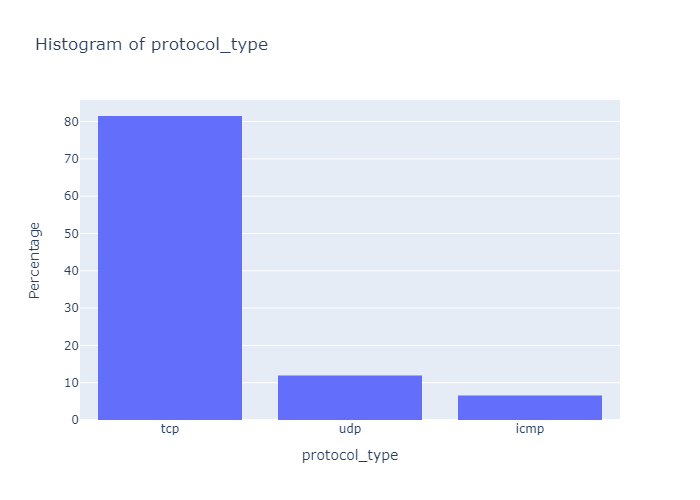

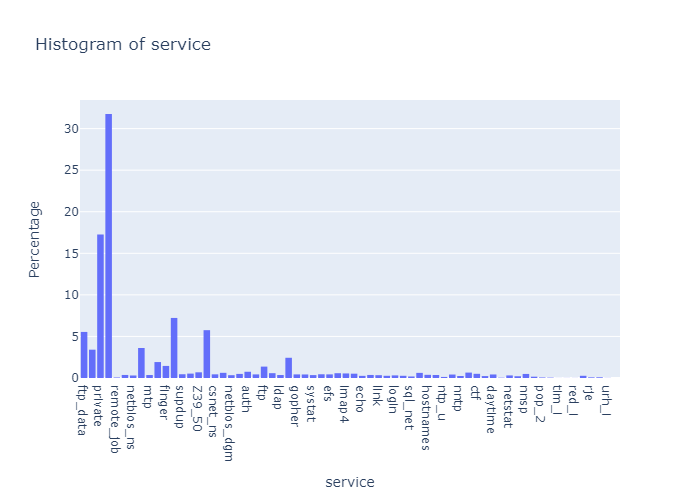

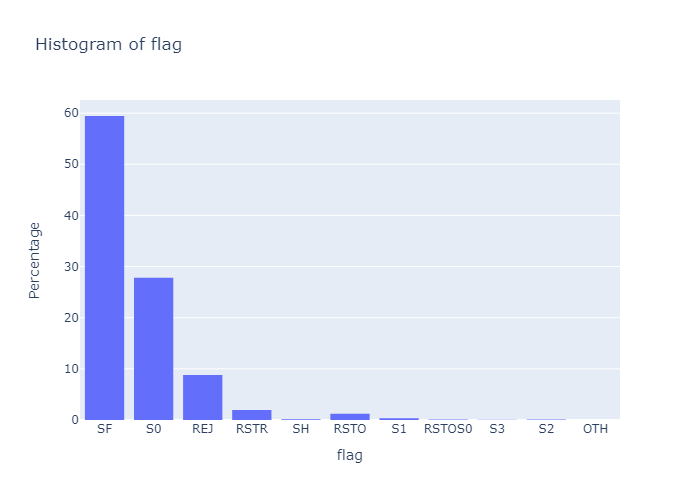

In [11]:
for v in categorical_features:
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=intrusion[v],
        nbinsx=len(intrusion[v].unique()), 
        histnorm='percent'
    ))
    fig.update_layout(
        title=f"Histogram of {v}",
        xaxis_title=v,
        yaxis_title='Percentage',
    )
    fig.show("png")


=> There are 3 categorical variables, protocol_type, service, flag. We explored the unique values each variable has, its frequency and most occurring value as well. We then plotted histograms to visualise the distribution of data for each individual variable better. We can observe that Tcp, http and SF are dominant values in their respective variables.


**2. Numerical Features**

=> To identify any strong linear relationships between pairs of numerical features which can help identify redundant features or multicollinearity, which might affect the performance of some machine learning models.

**A. Correlation Analysis**

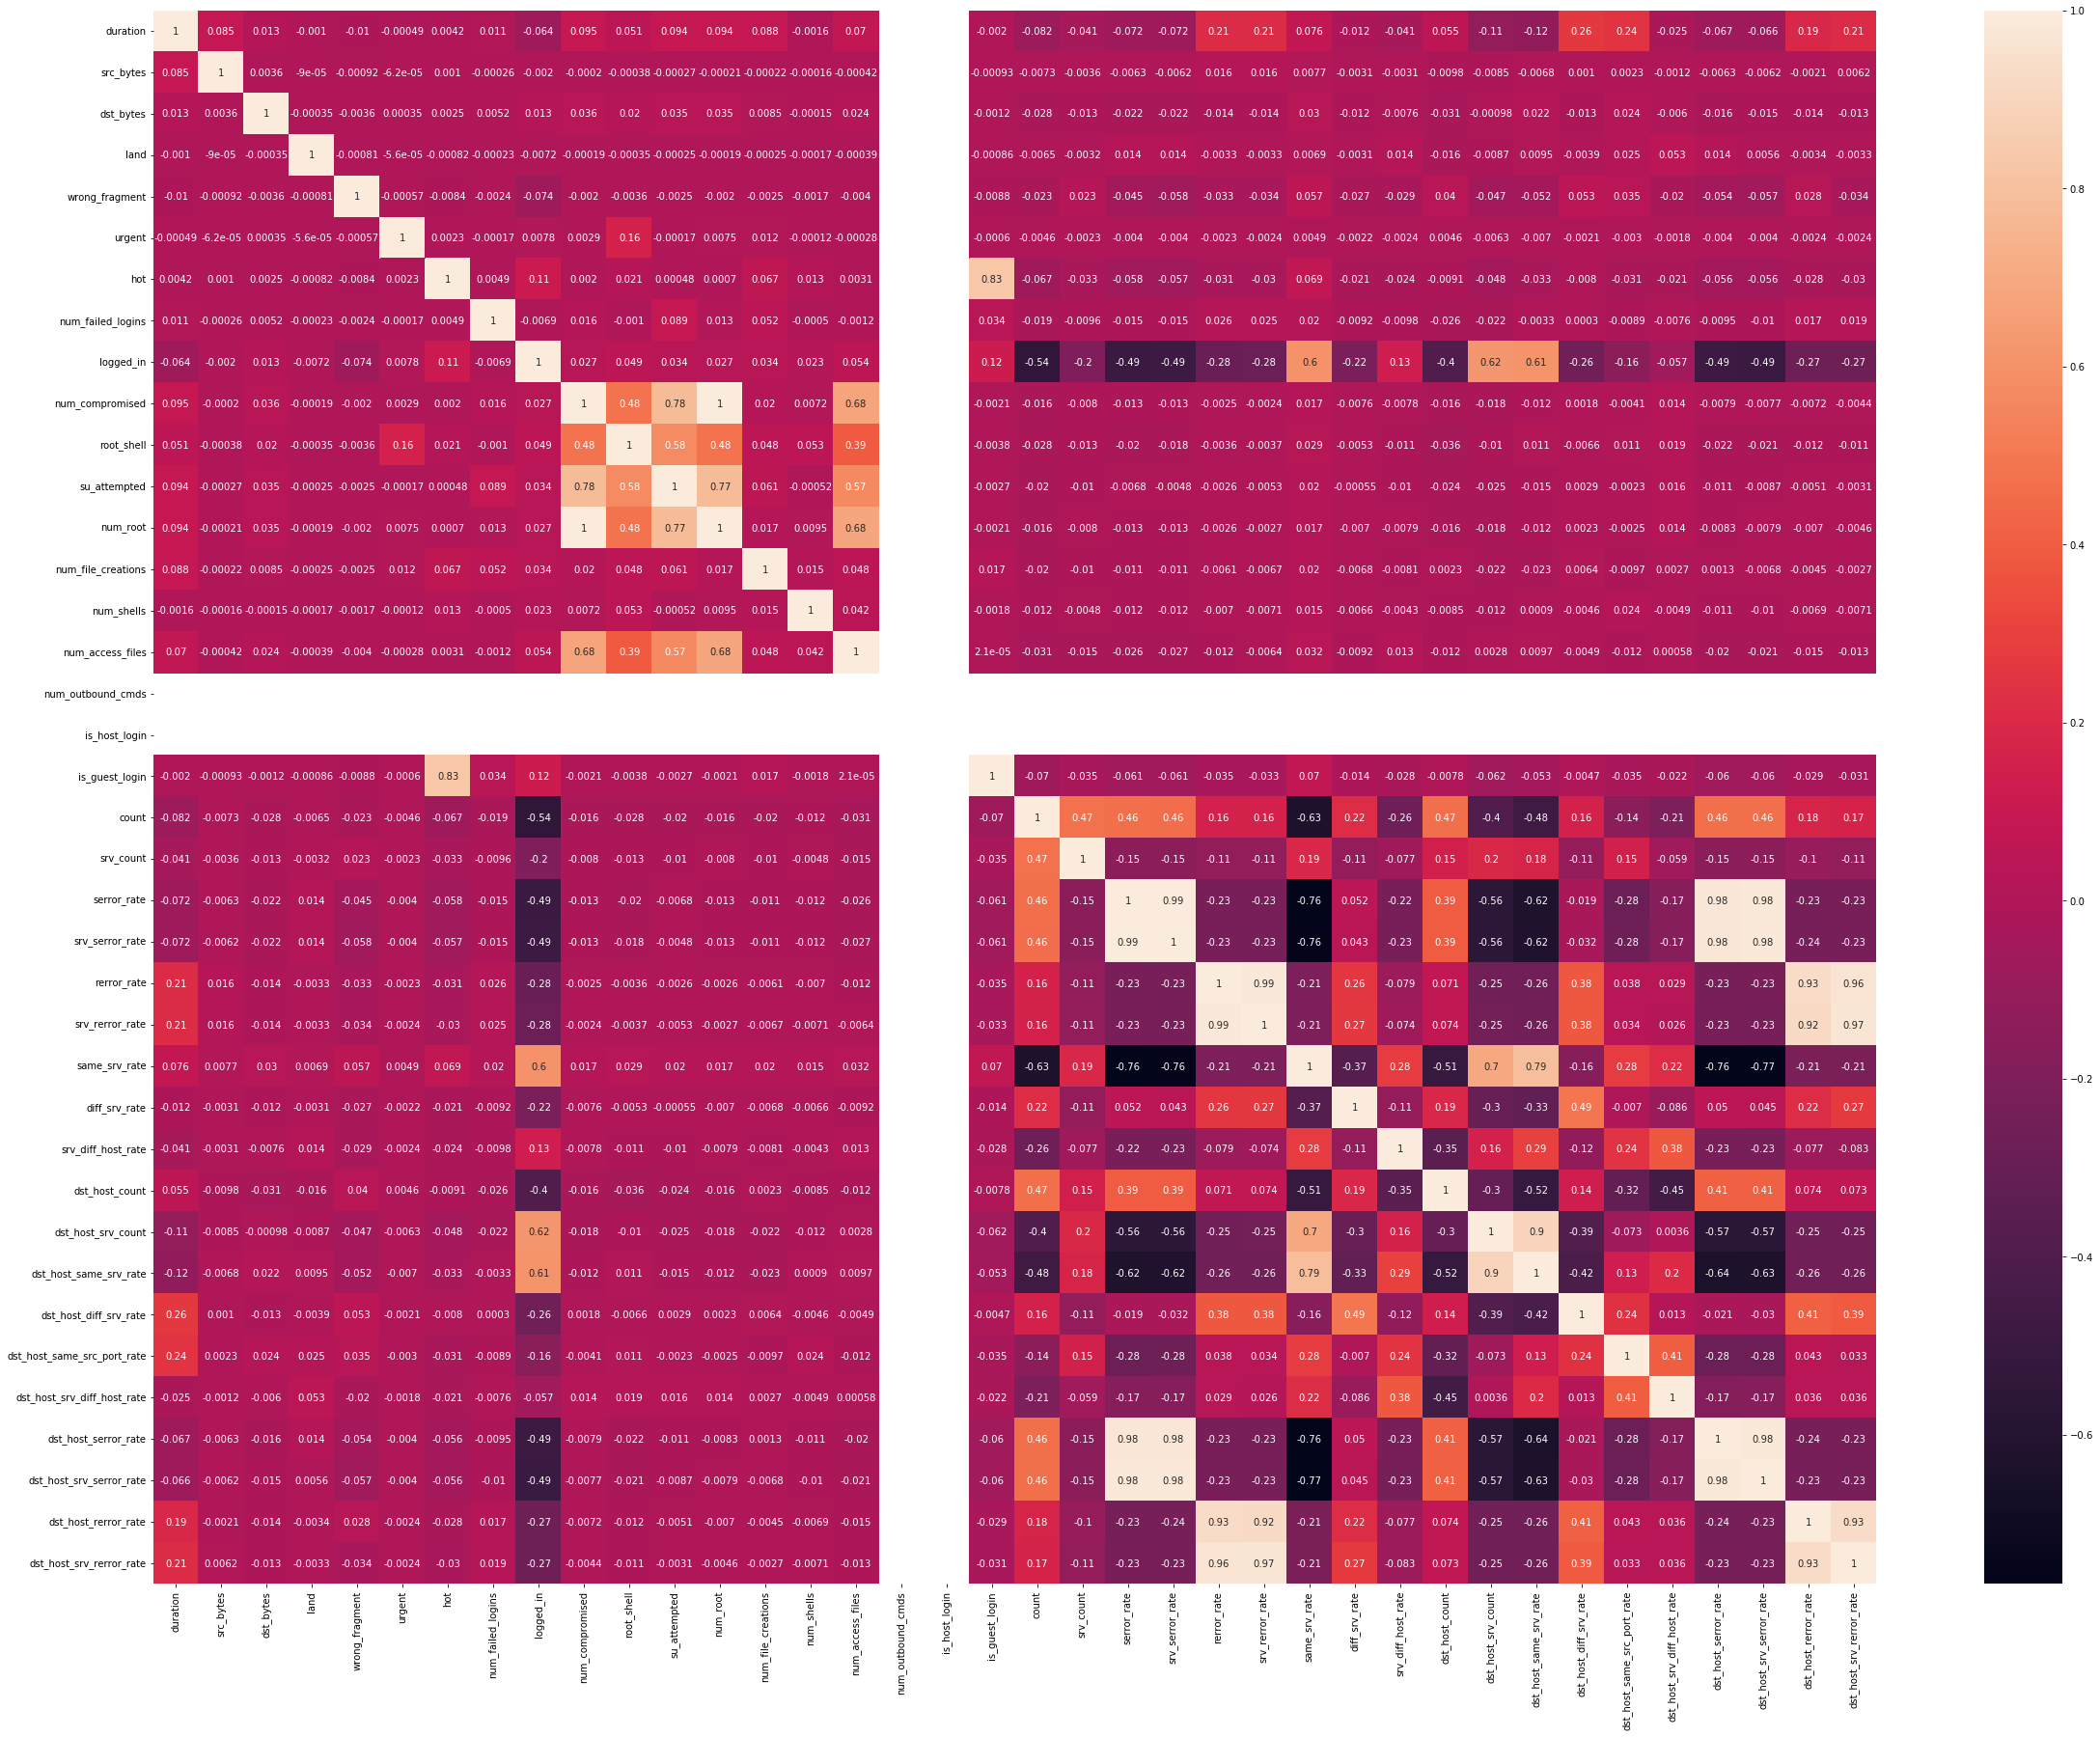

In [12]:
plt.figure(figsize=(40,30))
sb.heatmap(intrusion.corr(), annot=True)

**B. Histograms**

Next, the univariate histograms of the features are plotted to give us preliminary understanding about the distributions.

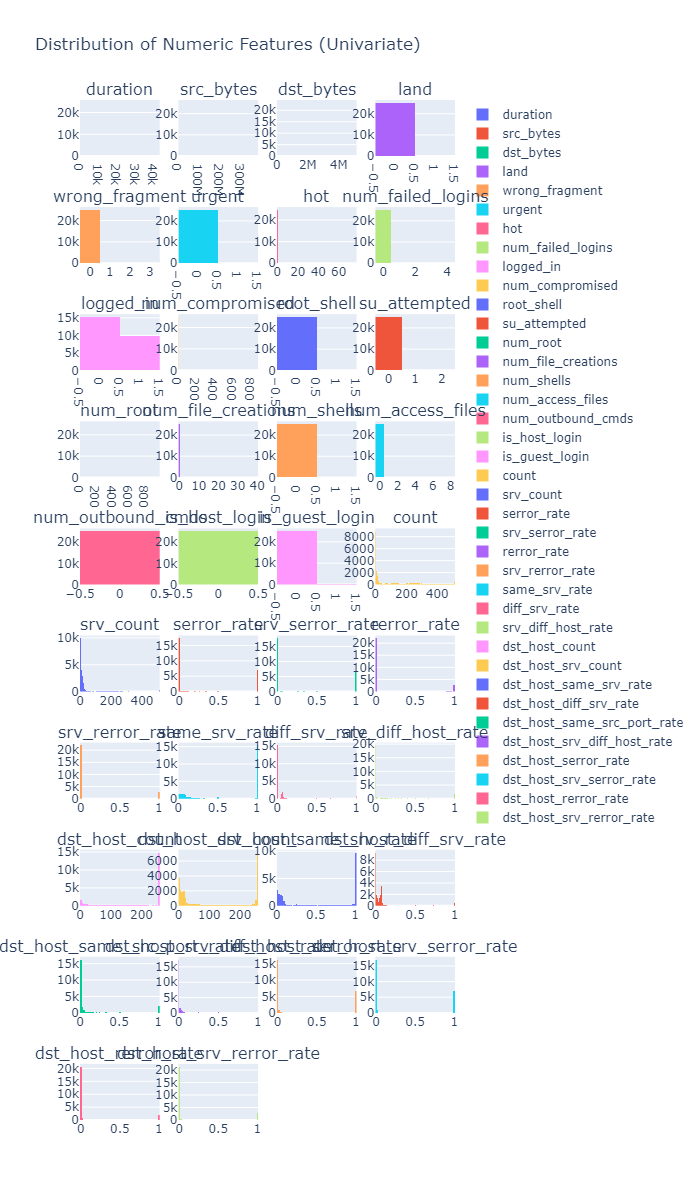

In [13]:
num_features = [column for column in intrusion.columns if column not in categorical_featureswclass]

subplots_layout = dict(rows=10, cols=4, subplot_titles=num_features)
subplot_fig = make_subplots(**subplots_layout)

finished = False
for row_idx in range(1, 11):
    if finished:
        break
    for col_idx in range(1, 5):
        feature_position = 4 * (row_idx - 1) + (col_idx - 1)
        if feature_position >= len(num_features):
            finished = True
            break
        current_feature = num_features[feature_position]
        feature_data = intrusion[current_feature]
        histogram_trace = go.Histogram(x=feature_data, name=current_feature)
        subplot_fig.add_trace(
            histogram_trace,
            row=row_idx,
            col=col_idx
        )

subplot_fig.update_layout(height=1200, title_text="Distribution of Numeric Features (Univariate)") 
subplot_fig.show("png")


**C. Statistical Dispersion and Variation**

=> Based on the observations of distributions above, some features behave as if they're constant features. We will look at two measures which will provide useful information about the dataset's characteristics

1. The proportion of the value with the most count in each feature
    - indicates the prevalence of the most common value within each feature
    
2. The variance of each feature
    - measure of the dispersion of values within a feature

In [14]:
n_samples = intrusion.shape[0]   # Total number of samples

# Get the proportion of the value with the most count in each feature
max_proportions = pd.DataFrame()
for f in num_features:
    feature_series = intrusion[f]
    max_proportion = np.max(feature_series.value_counts()) / n_samples
    max_proportions[f] = [max_proportion]
max_proportions.index = ["Max Proportion"]

# Get the variance of each feature 
vars = pd.DataFrame(intrusion.var()).T
vars.index = ["Variance"]

disp_and_var = max_proportions.append(vars)
print("=====Statistical dispersion and variation=====")
display(disp_and_var)

=====Statistical dispersion and variation=====


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Max Proportion,9.196570e-01,3.916323e-01,5.388218e-01,0.999921,0.991108,0.99996,0.979359,0.999087,0.605232,0.989203,...,0.589473,0.283741,0.387345,0.370872,0.503057,0.690179,0.643895,0.675016,0.821213,0.847452
Variance,7.217581e+06,5.811983e+12,7.890897e+09,0.000079,0.067715,0.00004,4.640585,0.002063,0.238936,108.521223,...,9799.791278,12242.725493,0.201551,0.035041,0.095090,0.012227,0.198307,0.198983,0.093556,0.100701


**3, Bivariate Analysis**

=> Before we begin the Bivariate Analysis, we decided to filter out the features with high max proportion or low variance based on the pre-defined thresholds to simplify the analysis. The thresholds are defined as follows:

1. Max proportion: 0.99
2. Variance: 0.001

=> We filter out these features to help reduce noise, improve accuracy and simplify the dataset by focusing on the most relevant features.

=> Next we plot scatter plots against the features in randomly picked pairs. This is to better visualise any potential linear relationships between any 2 features and quantify the strength of their relationship if needed.

After filtering, there are 25 numeric features remained.


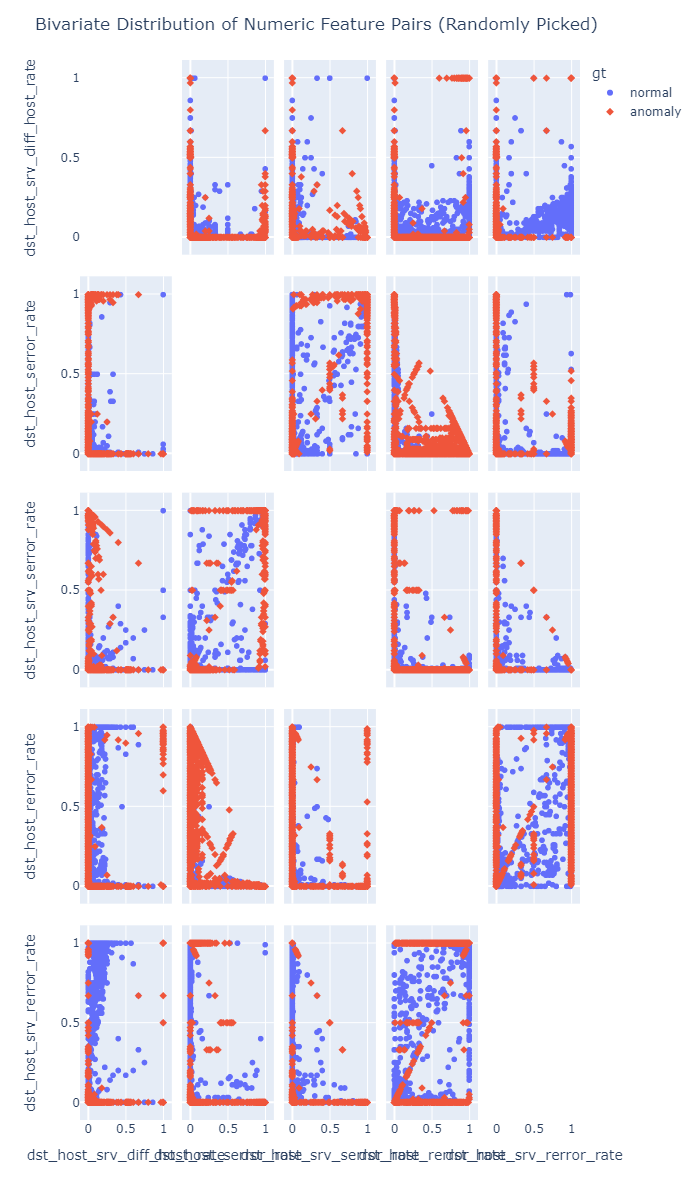

In [15]:
# Filter out features with high "max proportion" or low "variance"
disp_and_var_T = disp_and_var.T   # Take the transpose
features_remained = disp_and_var_T[(disp_and_var_T['Max Proportion'] < 0.99) & disp_and_var_T['Variance'] > 0.001].index.tolist()
intrusion = intrusion.loc[:, features_remained]
print(f"After filtering, there are {len(features_remained)} numeric features remained.")

# Plot bivariate distributions 
features_picked = features_remained[-5:]
df_train = intrusion.loc[:, features_picked]
df_train['gt'] = clss
fig = px.scatter_matrix(df_train, 
                        dimensions=features_picked,
                        color="gt", 
                        symbol="gt")
fig.update_traces(diagonal_visible=False)
fig.update_layout(height=1200, title_text="Bivariate Distribution of Numeric Feature Pairs (Randomly Picked)") 
fig.show("png")

**4. Checking for Class Imbalance**

=> We plot to see if there is an issue of class imbalance using the class column provided in the dataset.

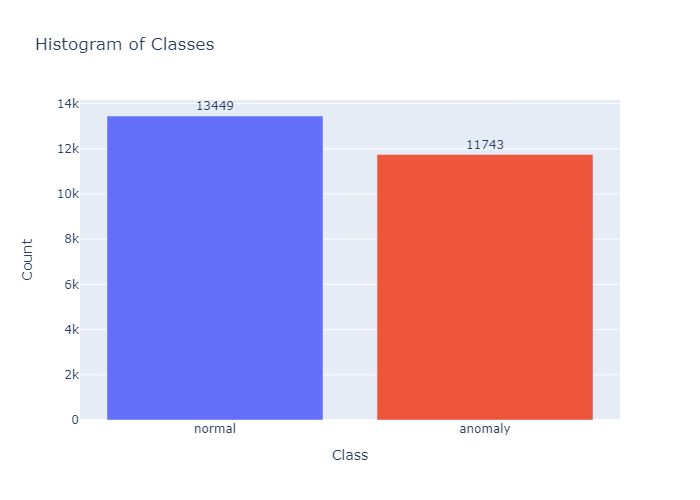

In [16]:


class_count = pd.DataFrame(clss).value_counts().reset_index()
class_count.columns = ['Class', 'Count']

fig = px.bar(class_count,
             x='Class',
             y='Count',
             color='Class',
             text='Count',
             labels={'Class': 'Class', 'Count': 'Count'},
             title='Histogram of Classes')

fig.update_layout(xaxis_title='Class', yaxis_title='Count', showlegend=False)
fig.update_traces(textposition='outside')
fig.show("png")



**We can observe that the  the classes of ‘normal’ and ‘anomaly’ are generally evenly distributed. and there is no severe issue of Class Imbalance. Anamoly in this cases refers to accesses classified as potentially dangerous**

## Machine Learning:

### Preparatory work before we begin

**1. Standardisation of the dataset as they might behave badly if the individual features do not more or less look like the standard normally distributed data, eg. for K-Nearest-Neighbours**

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = intrusionog.select_dtypes(include=['float64','int64']).columns
sc_intrusion = scaler.fit_transform(intrusionog.select_dtypes(include=['float64','int64']))


# turn the result back to a dataframe
sc_intrusiondf = pd.DataFrame(sc_intrusion, columns = cols)


**2. Encoding categorical attributes to make it compatible with numeric data when using models**

In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes  
catintrusion = intrusionog.select_dtypes(include=['object']).copy()

# encode the categorical attributes
intrusioncat = catintrusion.apply(encoder.fit_transform)


# separate target column from encoded data 
encintrusion = intrusioncat.drop(['class'], axis=1)
cat_intrusion = intrusioncat[['class']].copy()

In [19]:
intrusion_x = pd.concat([sc_intrusiondf,encintrusion],axis=1)
intrusion_y = intrusionog['class']
intrusion_x.shape

(25192, 41)

**3. Performing Feature Importance**

=> Using Random Forests and Recursive Feature Elimination to rank the importance of features to identify the most relevant ones for the anomaly detection to reduce the complexity of the dataset.

=> Feature selection can also improve the performance of the model by reducing the risk of overfitting

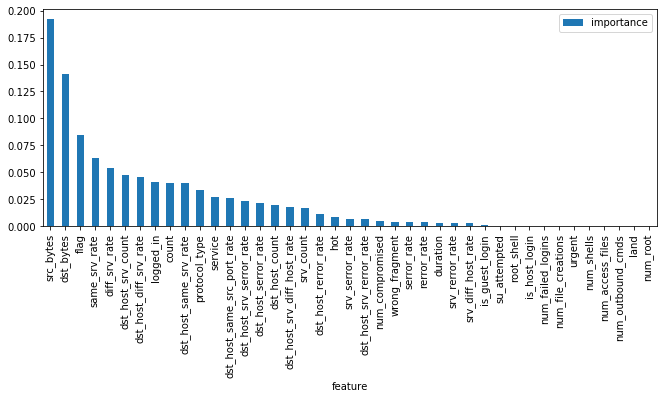

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(intrusion_x, intrusion_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':intrusion_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [21]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(intrusion_x, intrusion_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), intrusion_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

In [22]:
selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

=> The random forest algorithm builds a forest in the form of an ensemble of decision trees, which adds more randomness while growing the trees. While splitting a node, the algorithm searches for the best features from the random subset of features, which adds more diversity, resulting in a better model.

=> RFE stands for Recursive Feature Elimination. It is effective at selecting those features (columns) in a training dataset that are more or most relevant in predicting the target variable.

=> src_bytes is the most important feature

***We focused on the top 15 features selected by the random forest classifier.***

**4. Train Test Split**

In [23]:
X_train,X_test,Y_train,Y_test = train_test_split(intrusion_x[selected_features],intrusion_y,train_size=0.80, random_state=2)

In [24]:
X_train.shape

(20153, 15)

In [25]:
X_test.shape

(5039, 15)

In [26]:
Y_train.shape

(20153,)

In [27]:
Y_test.shape

(5039,)

### ML Models

**1. Decision tree (Baseline Model)**

=> We chose Decision Tree as our baseline because of its versatility and that it doesnt require a lot of assumptions that need to be fulfilled for the model to work efficiently. It is also easily interpretable.

In [28]:
dt = DecisionTreeClassifier(max_depth=4) #take an arbitrary value first


# Measure the time taken to fit the model
start_time = time.time()
dt.fit(X_train, Y_train)
fit_timedtog = time.time() - start_time

# Measure the accuracy of the model on the training and test set
dt_trainog, dt_testog = dt.score(X_train, Y_train), dt.score(X_test, Y_test)

# Measure the time taken to generate predictions
start_time = time.time()
y_pred = dt.predict(X_test)
predict_timedtog = time.time() - start_time

# Calculate the precision score
precisiondtog = precision_score(Y_test, y_pred, average='macro')

# Print the accuracy and time taken for fitting and predicting
print(f"Train Score: {dt_trainog}")
print(f"Test Score: {dt_testog}")
print(f"Precision: {precisiondtog}")
print(f"Time taken to fit the model: {fit_timedtog:.10f} seconds")
print(f"Time taken to generate predictions: {predict_timedtog:.10f} seconds")

Train Score: 0.9770257529896293
Test Score: 0.9740027783290336
Precision: 0.9735761882932672
Time taken to fit the model: 0.0673127174 seconds
Time taken to generate predictions: 0.0020306110 seconds


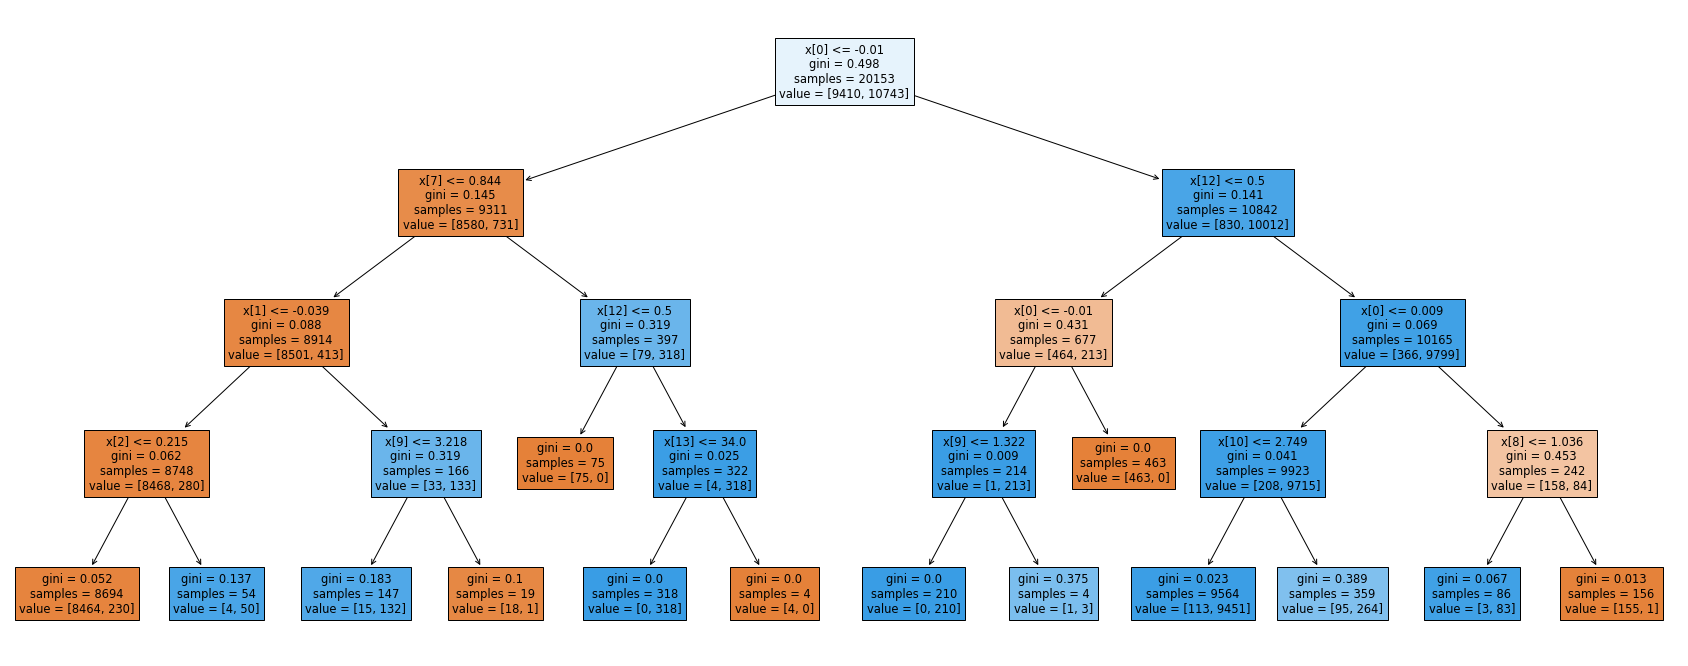

In [29]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

=> The depth we chose was an arbitrary number of 4, taken from  a random number generator of integers 1 to 10.

=> The results were fairly accurate, but we aimed to make it better by using Optuna to optimize the decision tree based on the parameters of max depth and max features.

**2. Decision tree (Optimised)**

In [30]:
def objective_DT(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32, log=False)
    max_features = trial.suggest_int('max_features', 2, 10, log=False)
    model = DecisionTreeClassifier(max_features=max_features, max_depth=max_depth)
    model.fit(X_train, Y_train)
    accuracy = model.score(X_test, Y_test)
    return accuracy


**Hyperparameter Tuning:**

For two hyperparameters, dt_max_depth and dt_max_features, the trial.suggest_int function is used to suggest integer values that fall within a specified range. The decision tree's maximum depth is specified by the max_depth hyperparameter, while the number of features that can be used to divide a node is specified by the max_features hyperparameter.

Using the specified hyperparameters, a new instance of the DecisionTreeClassifier class is constructed and fitted to the training set of data. The scoring technique is then used to the test data to determine the classifier's accuracy.


The accuracy value is displayed as the process' goal for tuning the hyperparameters. Finding the set of hyperparameters that maximizes the Decision Tree classifier's accuracy on the test data is the aim of the hyperparameter tuning process.

In [31]:
study_dt = optuna.create_study(direction='maximize')

# Measure the time taken to run the Optuna study
start_time = time.time()
study_dt.optimize(objective_DT, n_trials=30)
optuna_timedt = time.time() - start_time

# Print the best trial from the Optuna study and the time taken to run the study
print(f"Best trial: {study_dt.best_trial}")
print(f"Time taken to run Optuna study: {optuna_timedt:.2f} seconds")

[I 2023-04-23 22:21:45,959] A new study created in memory with name: no-name-9e47f8fa-6c59-43bb-b86f-89a2808901c5
[I 2023-04-23 22:21:46,010] Trial 0 finished with value: 0.9593173248660448 and parameters: {'max_depth': 3, 'max_features': 4}. Best is trial 0 with value: 0.9593173248660448.
[I 2023-04-23 22:21:46,058] Trial 1 finished with value: 0.9912681087517364 and parameters: {'max_depth': 31, 'max_features': 2}. Best is trial 1 with value: 0.9912681087517364.
[I 2023-04-23 22:21:46,110] Trial 2 finished with value: 0.96765231196666 and parameters: {'max_depth': 6, 'max_features': 2}. Best is trial 1 with value: 0.9912681087517364.
[I 2023-04-23 22:21:46,187] Trial 3 finished with value: 0.9920619170470332 and parameters: {'max_depth': 28, 'max_features': 7}. Best is trial 3 with value: 0.9920619170470332.
[I 2023-04-23 22:21:46,237] Trial 4 finished with value: 0.9904743004564398 and parameters: {'max_depth': 18, 'max_features': 2}. Best is trial 3 with value: 0.9920619170470332.


Best trial: FrozenTrial(number=23, state=TrialState.COMPLETE, values=[0.9948402460805715], datetime_start=datetime.datetime(2023, 4, 23, 22, 21, 47, 735260), datetime_complete=datetime.datetime(2023, 4, 23, 22, 21, 47, 822967), params={'max_depth': 16, 'max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=23, value=None)
Time taken to run Optuna study: 2.40 seconds


**Using Optuna Library**

The goal of this code is to use the Optuna library to perform hyperparameter tuning for a Decision Tree classifier and print out the optimal set of hyperparameters.

The direction argument of the optuna.create_study(direction='maximize') function  generates a new study object for hyperparameter optimization, indicating that we wish to maximize the objective function (in this example, the accuracy).

Using the objective function objective and a total of 30 trials, the study_dt.optimize(objective, n_trials=30) function is used to optimize the Decision Tree classifier's hyperparameters. Optuna proposes a fresh set of hyperparameters for each trial and assesses how well they perform using the objective function. Based on the results of each trial, Optuna updates its internal model to guide the search towards promising regions of the hyperparameter space.

In [32]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['max_features'], max_depth = study_dt.best_trial.params['max_depth'])

# Measure the time taken to fit the model
start_time = time.time()
dt.fit(X_train, Y_train)
fit_timedt = time.time() - start_time

# Measure the accuracy of the model on the training and test set
dt_train, dt_test = dt.score(X_train, Y_train), dt.score(X_test, Y_test)

# Measure the time taken to generate predictions
start_time = time.time()
y_pred = dt.predict(X_test)
predict_timedt = time.time() - start_time

# Calculate the precision score
precisiondt = precision_score(Y_test, y_pred, average='macro')

# Print the accuracy and time taken for fitting and predicting
print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")
print(f"Precision: {precisiondt}")
print(f"Time taken to fit the model: {fit_timedt:.10f} seconds")
print(f"Time taken to generate predictions: {predict_timedt:.10f} seconds")

Train Score: 1.0
Test Score: 0.9946417940067473
Precision: 0.9944628689204507
Time taken to fit the model: 0.0957169533 seconds
Time taken to generate predictions: 0.0019946098 seconds


The average parameter must be set when the multi-class classification is done in order to use the **precision_score function**.

We utilize macro because it treats the two classes equally and reduces biases between them. 

Precision demonstrates that it generates fewer unfavorable predictions. 

Hence, when considering an intrusion detection system, is equally crucial.

***Performace is improved after optimisation***

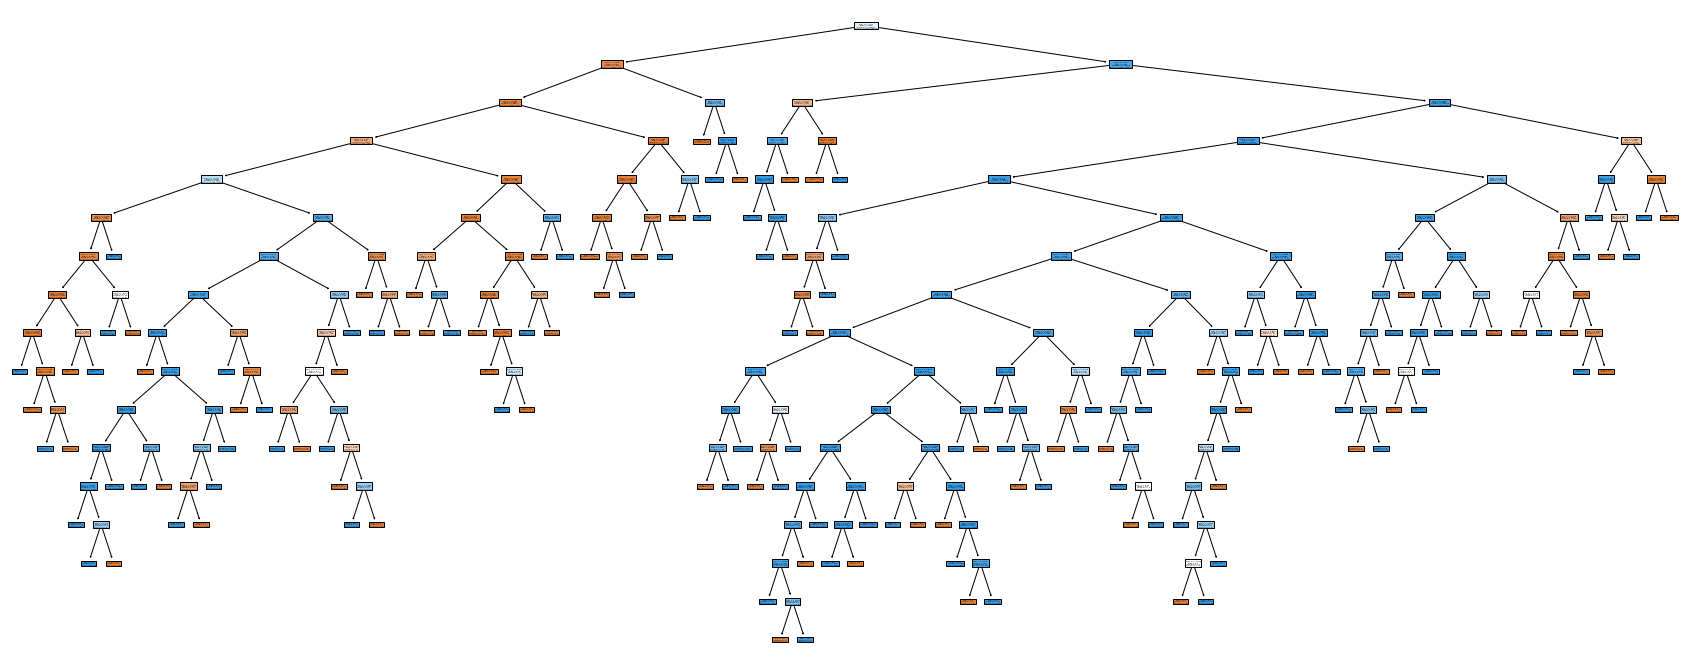

In [33]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

**Now we carry out with other machine learning models WITH OPTIMISATION**

**2. K Nearest Neighbours**

=> KNN is a non-parametric algorithm, meaning it does not make any assumptions about the underlying distribution of the data. 
Instead, it relies on the distances between data points to make predictions. It is supervised machine learning algorithm that can be used to solve both classification and regression problems using feature similarity making it popular for anomaly detection.

=> We also used Optuna to optimize it based on the parameter of K, which is the number of nearest neighbors.


In [34]:
def objective_KNN(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(X_train, Y_train)
    accuracy = classifier_obj.score(X_test, Y_test)
    return accuracy


In [35]:
study_KNN = optuna.create_study(direction='maximize')

# Measure the time taken to run the Optuna study
start_time = time.time()
study_KNN.optimize(objective_KNN, n_trials=1)
optuna_timeknn = time.time() - start_time

# Print the best trial from the Optuna study and the time taken to run the study
print(f"Best trial: {study_KNN.best_trial}")
print(f"Time taken to run Optuna study: {optuna_timeknn:.2f} seconds")

[I 2023-04-23 22:21:57,037] A new study created in memory with name: no-name-a9b932b7-6692-4019-9c2d-acf99a547583
[I 2023-04-23 22:21:57,814] Trial 0 finished with value: 0.9867037110537805 and parameters: {'KNN_n_neighbors': 4}. Best is trial 0 with value: 0.9867037110537805.


Best trial: FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9867037110537805], datetime_start=datetime.datetime(2023, 4, 23, 22, 21, 57, 39663), datetime_complete=datetime.datetime(2023, 4, 23, 22, 21, 57, 813696), params={'KNN_n_neighbors': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)
Time taken to run Optuna study: 0.78 seconds


In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
import time

# Initialize the KNN classifier
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])

# Measure the time taken to fit the model
start_time = time.time()
KNN_model.fit(X_train, Y_train)
fit_timeknn = time.time() - start_time

# Measure the accuracy of the model on the training and test set
KNN_train, KNN_test = KNN_model.score(X_train, Y_train), KNN_model.score(X_test, Y_test)

# Measure the time taken to generate predictions
start_time = time.time()
y_pred = KNN_model.predict(X_test)
predict_timeknn = time.time() - start_time

# Calculate the precision score
precisionKnn = precision_score(Y_test, y_pred, average='macro')

# Print the precision score and time taken for fitting and predicting
print(f"Precision: {precisionKnn}")
print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")
print(f"Time taken to fit the model: {fit_timeknn:.10f} seconds")
print(f"Time taken to generate predictions: {predict_timeknn:.10f} seconds")


Precision: 0.9862194946510411
Train Score: 0.9929539026447676
Test Score: 0.9867037110537805
Time taken to fit the model: 0.1312632561 seconds
Time taken to generate predictions: 0.6995882988 seconds


**3. logistics Regression**

=> Logistic regression is a fast and accurate algorithm. It's a process of modelling the probability of a discrete outcome which is applicable in our scenario as Logistic Regression models a binary outcome of Normal or Anomalous.

=> We optimized it based on L2, which introduces a penalty term that encourages the model to have smaller values for the coefficients of the regression, effectively shrinking them towards zero to prevent overfitting.

In [37]:
def objective_lg(trial):
    # Define the hyperparameters to optimize
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    penalty = trial.suggest_categorical('penalty', [ 'l2'])

    # Train a logistic regression model with the chosen hyperparameters
    lg_model = LogisticRegression(C=C, penalty=penalty)
    lg_model.fit(X_train, Y_train)

    # Evaluate the model on the test set and return the accuracy score as the objective value
    Y_pred = lg_model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    return accuracy

In [38]:
study_lg = optuna.create_study(direction='maximize')

start_time = time.time()
study_lg.optimize(objective_lg, n_trials=30)
optuna_timelg = time.time() - start_time

# Print the best trial from the Optuna study
print(study_lg.best_trial)
print(f"Time taken to run Optuna study: {optuna_timelg:.2f} seconds")

[I 2023-04-23 22:22:03,109] A new study created in memory with name: no-name-680209a5-60ce-4e20-aa9e-aaa03f52e2b5
[I 2023-04-23 22:22:03,362] Trial 0 finished with value: 0.937487596745386 and parameters: {'C': 1.8478721760349364, 'penalty': 'l2'}. Best is trial 0 with value: 0.937487596745386.
[I 2023-04-23 22:22:03,615] Trial 1 finished with value: 0.9378845008930343 and parameters: {'C': 102.32739465878566, 'penalty': 'l2'}. Best is trial 1 with value: 0.9378845008930343.
[I 2023-04-23 22:22:03,872] Trial 2 finished with value: 0.9376860488192101 and parameters: {'C': 0.017201958599126693, 'penalty': 'l2'}. Best is trial 1 with value: 0.9378845008930343.
[I 2023-04-23 22:22:04,135] Trial 3 finished with value: 0.937487596745386 and parameters: {'C': 1793.6688164809234, 'penalty': 'l2'}. Best is trial 1 with value: 0.9378845008930343.
[I 2023-04-23 22:22:04,405] Trial 4 finished with value: 0.937487596745386 and parameters: {'C': 66427.97778291207, 'penalty': 'l2'}. Best is trial 1 w

FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.9392736654098035], datetime_start=datetime.datetime(2023, 4, 23, 22, 22, 9, 958584), datetime_complete=datetime.datetime(2023, 4, 23, 22, 22, 10, 305969), params={'C': 0.04143769288845429, 'penalty': 'l2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100000.0, log=True, low=1e-05, step=None), 'penalty': CategoricalDistribution(choices=('l2',))}, trial_id=26, value=None)
Time taken to run Optuna study: 8.24 seconds


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import time

# Initialize the logistic regression classifier
lg_model = LogisticRegression(C=study_lg.best_trial.params['C'], penalty=study_lg.best_trial.params['penalty'])

# Measure the time taken to fit the model
start_time = time.time()
lg_model.fit(X_train, Y_train)
fit_timelg = time.time() - start_time

# Measure the accuracy of the model on the training and test set
lg_train, lg_test = lg_model.score(X_train, Y_train), lg_model.score(X_test, Y_test)

# Measure the time taken to generate predictions
start_time = time.time()
y_pred = lg_model.predict(X_test)
predict_timelg = time.time() - start_time

# Calculate the precision score
precisionlg = precision_score(Y_test, y_pred, average='macro')

# Print the precision score and time taken for fitting and predicting
print(f"Precision: {precisionlg}")
print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")
print(f"Time taken to fit the model: {fit_timelg:.10f} seconds")
print(f"Time taken to generate predictions: {predict_timelg:.10f} seconds")


Precision: 0.9398239531814061
Training Score: 0.9441770456011512
Test Score: 0.9392736654098035
Time taken to fit the model: 0.3395702839 seconds
Time taken to generate predictions: 0.0029547215 seconds


### Perfomance Metrics

**=> Metrics Chosen:**

    1. Precision
    2. Time to Fit
    3. Time to Predict
    
**=> Why we Chose them?:**

    - Time taken to classify network accesses is crucial as the system should be able to detect an attack almost instantly              to prevent simultaneous attacks
    - Accuracy measures how often the model makes correct predictions
    - Precision measures how many of the positive predictions made by the model are actually correct
    
***We need to prevent as many false positives as possible as it can be costly in terms of time, resources,  as they can trigger unnecessary alerts and investigations, causing distractions and delays. This can cause holes in the system which can possibly lead to more attacks.***
    

In [40]:
data = [["KNN", KNN_train, KNN_test,precisionKnn,fit_timeknn,predict_timeknn,optuna_timeknn], 
        ["Logistic Regression", lg_train, lg_test,precisionlg,fit_timelg,predict_timelg,optuna_timelg],
        ["Decision Tree", dt_train, dt_test,precisiondt,fit_timedt,predict_timedt,optuna_timedt]] 
       

col_names = ["Model", "Train Score", "Test Score","Precision","Time to Fit","Time to Predict","Optimisation time"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))



╒═════════════════════╤═══════════════╤══════════════╤═════════════╤═══════════════╤═══════════════════╤═════════════════════╕
│ Model               │   Train Score │   Test Score │   Precision │   Time to Fit │   Time to Predict │   Optimisation time │
╞═════════════════════╪═══════════════╪══════════════╪═════════════╪═══════════════╪═══════════════════╪═════════════════════╡
│ KNN                 │      0.992954 │     0.986704 │    0.986219 │      0.131263 │        0.699588   │            0.776283 │
├─────────────────────┼───────────────┼──────────────┼─────────────┼───────────────┼───────────────────┼─────────────────────┤
│ Logistic Regression │      0.944177 │     0.939274 │    0.939824 │      0.33957  │        0.00295472 │            8.24429  │
├─────────────────────┼───────────────┼──────────────┼─────────────┼───────────────┼───────────────────┼─────────────────────┤
│ Decision Tree       │      1        │     0.994642 │    0.994463 │      0.095717 │        0.00199461 │       

**Findings**

=> Most accurate: 

       Decision Tree: Highest Precision

 

**Analysis**

=> For the optimised models using the hyperparameters given by the tuning process, based on the results above the most accurate and precise model to use is the optimized decision tree which is our baseline model but optimised. 

=>However, we need to take into account the optimization time, which is more than three times that of KNN since time taken for the whole model is important as intrusion detection is done in real-time. 
 

## Conclusion

**Improving our Models**

=> To improve time and accuracy, we suggest parallel processing algorithms and gradient boosting models such as XGBoost or sklearn. Gradient boosting improves accuracy by iteratively combining the predictions of weak learners, while parallel processing focuses on splitting the data and running the algorithms on multiple processors which will greatly speed up the models.

**Our Conclusion**

=> All models perform similarly with each with its own strengths as mentioned before in our analysis. 

=> We believe that the next best steps for companies would be to use multiple models together and leverage their strengths to improve speed and accuracy which are key for a detection system